In [2]:
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData

# 3DGS 데이터 로드 함수 (제공된 코드)
def load_3dgs_data_with_attributes(path_3dgs):
    """
    Load 3DGS data with attributes from a PLY file.
    
    Args:
        path_3dgs (str): Path to the 3DGS PLY file
    
    Returns:
        points_3dgs (np.ndarray): 3DGS points [N, 3]
        colors_3dgs (np.ndarray): 3DGS colors [N, 3]
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
    """
    with open(path_3dgs, 'rb') as f:
        ply_data_3dgs = PlyData.read(f)
    vertex_data_3dgs = ply_data_3dgs['vertex']
    
    points_3dgs = np.stack([vertex_data_3dgs['x'], vertex_data_3dgs['y'], vertex_data_3dgs['z']], axis=-1)
    
    # SH 1차 계수 (f_dc_0, f_dc_1, f_dc_2) -> RGB
    colors_3dgs = np.stack([vertex_data_3dgs['f_dc_0'], vertex_data_3dgs['f_dc_1'], vertex_data_3dgs['f_dc_2']], axis=-1)
    # SH 계수는 일반적으로 [-1, 1] 범위로 저장됨 -> [0, 1]로 정규화
    colors_3dgs = (colors_3dgs + 1.0) / 2.0  # [-1, 1] -> [0, 1]
    colors_3dgs = np.clip(colors_3dgs, 0.0, 1.0)  # 범위 제한

    scales_3dgs = np.stack([vertex_data_3dgs['scale_0'], vertex_data_3dgs['scale_1'], vertex_data_3dgs['scale_2']], axis=-1)
    opacity_3dgs = vertex_data_3dgs['opacity']
    rotation_3dgs = np.stack([vertex_data_3dgs['rot_0'], vertex_data_3dgs['rot_1'], vertex_data_3dgs['rot_2'], vertex_data_3dgs['rot_3']], axis=-1)  # Quaternion (w, x, y, z)
    
    features_3dgs = np.hstack((scales_3dgs, opacity_3dgs[:, np.newaxis], rotation_3dgs))
    return points_3dgs, colors_3dgs, features_3dgs

=== 원본 속성 분석 ===

Scale (Original) 통계:
최소값: -16.7282
최대값: 0.2799
평균: -4.2062
표준편차: 1.0132
NaN 값 개수: 0
Inf 값 개수: 0


/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from cu

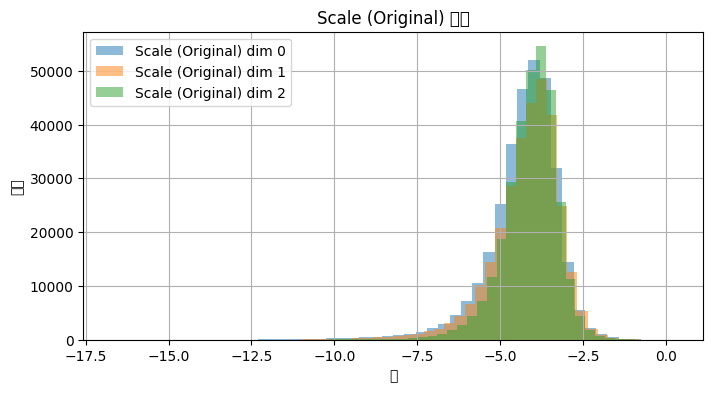


Opacity (Original) 통계:
최소값: -6.8292
최대값: 10.8740
평균: -1.6189
표준편차: 1.9291
NaN 값 개수: 0
Inf 값 개수: 0


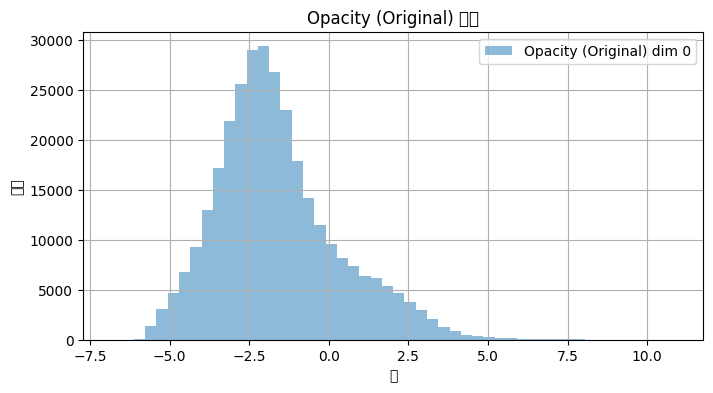


Rotation (Original, Quaternion) 통계:
최소값: -0.9625
최대값: 2.2201
평균: 0.2354
표준편차: 0.4430
NaN 값 개수: 0
Inf 값 개수: 0


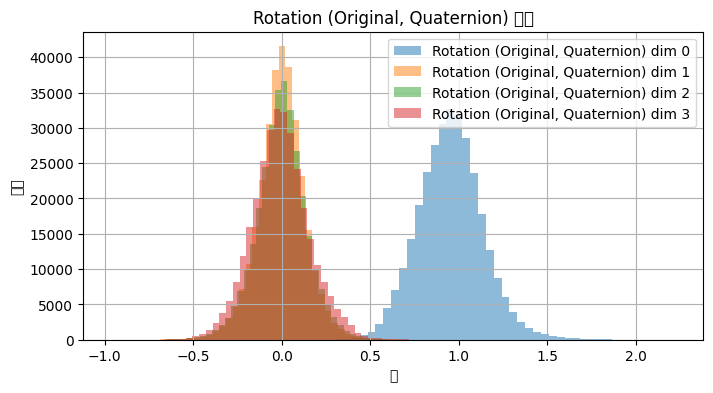


=== 후처리 후 속성 분석 ===

Scale (Processed) 통계:
최소값: 0.0000
최대값: 1.3230
평균: 0.0217
표준편차: 0.0202
NaN 값 개수: 0
Inf 값 개수: 0


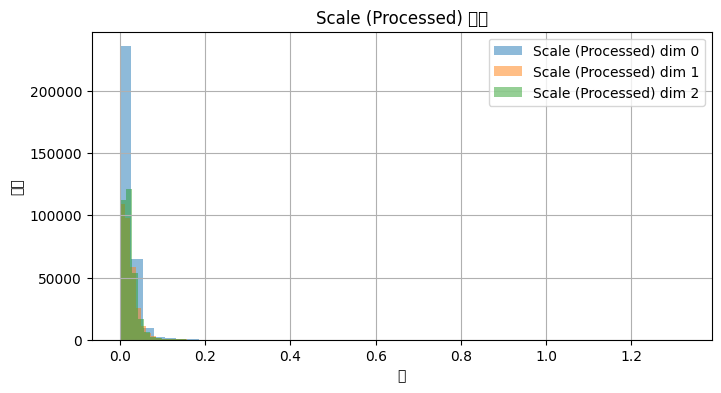


Opacity (Processed) 통계:
최소값: 0.0011
최대값: 1.0000
평균: 0.2503
표준편차: 0.2766
NaN 값 개수: 0
Inf 값 개수: 0


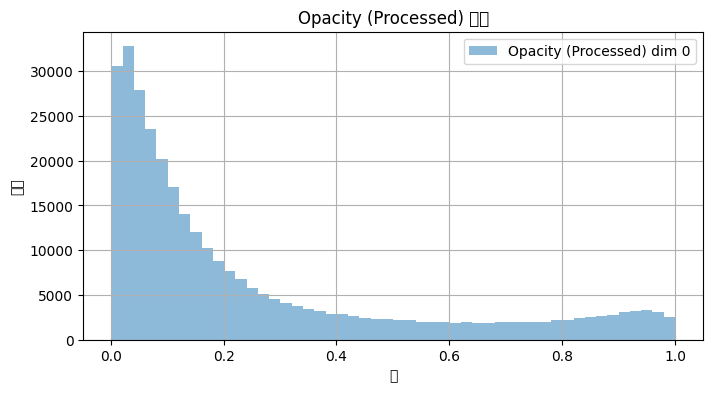


Rotation (Processed, Quaternion) 통계:
최소값: -0.9355
최대값: 1.0000
평균: 0.2360
표준편차: 0.4408
NaN 값 개수: 0
Inf 값 개수: 0


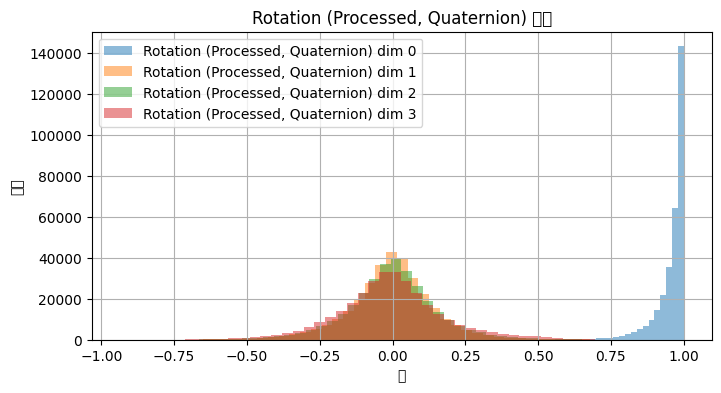


=== 활용 예시: 후처리된 속성 분석 ===
Scale이 1e-5보다 작은 가우시안 개수: 0
Opacity가 0.1보다 작은 가우시안 개수: 134004


In [3]:
# 후처리 함수
def postprocess_3dgs_attributes(scale, opacity, rotation):
    """
    Postprocess 3DGS attributes to make them usable.
    
    Args:
        scale (np.ndarray): Log-transformed scale values [N, 3]
        opacity (np.ndarray): Raw logit opacity values [N, 1]
        rotation (np.ndarray): Quaternion values [N, 4]
    
    Returns:
        scale_processed (np.ndarray): Original scale values [N, 3]
        opacity_processed (np.ndarray): Sigmoid-transformed opacity values [N, 1]
        rotation_processed (np.ndarray): Normalized quaternion values [N, 4]
    """
    # Scale: 로그 변환 해제
    scale_processed = np.exp(scale)  # log(scale) -> scale
    scale_processed = np.nan_to_num(scale_processed, nan=1e-6, posinf=1e-6, neginf=1e-6)
    scale_processed = np.maximum(scale_processed, 1e-6)  # 양수 보장

    # Opacity: 시그모이드 변환
    opacity_processed = 1 / (1 + np.exp(-opacity))  # [-∞, ∞] -> [0, 1]
    opacity_processed = np.nan_to_num(opacity_processed, nan=0.0, posinf=1.0, neginf=0.0)
    opacity_processed = np.clip(opacity_processed, 0.0, 1.0)  # [0, 1]로 클리핑

    # Rotation: 쿼터니언 정규화
    rotation_norm = np.linalg.norm(rotation, axis=1, keepdims=True)
    rotation_processed = np.where(rotation_norm > 0, rotation / rotation_norm, rotation)

    return scale_processed, opacity_processed, rotation_processed

# 통계 정보 출력 함수
def print_stats(data, name):
    print(f"\n{name} 통계:")
    print(f"최소값: {np.min(data):.4f}")
    print(f"최대값: {np.max(data):.4f}")
    print(f"평균: {np.mean(data):.4f}")
    print(f"표준편차: {np.std(data):.4f}")
    print(f"NaN 값 개수: {np.isnan(data).sum()}")
    print(f"Inf 값 개수: {np.isinf(data).sum()}")

# 히스토그램 시각화 함수
def plot_histogram(data, name, bins=50):
    plt.figure(figsize=(8, 4))
    if data.ndim == 2:
        for i in range(data.shape[1]):
            plt.hist(data[:, i], bins=bins, alpha=0.5, label=f"{name} dim {i}")
    else:
        plt.hist(data, bins=bins, alpha=0.5, label=name)
    plt.title(f"{name} 분포")
    plt.xlabel("값")
    plt.ylabel("빈도")
    plt.legend()
    plt.grid(True)
    plt.show()

# 메인 처리
def process_3dgs_attributes(ply_path):
    # 데이터 로드
    points, colors, features = load_3dgs_data_with_attributes(ply_path)
    
    # 속성 분리
    scale = features[:, 0:3]  # [N, 3]
    opacity = features[:, 3:4]  # [N, 1]
    rotation = features[:, 4:8]  # [N, 4] (쿼터니언: rot_w, rot_x, rot_y, rot_z)

    # 원본 속성 분석
    print("=== 원본 속성 분석 ===")
    print_stats(scale, "Scale (Original)")
    plot_histogram(scale, "Scale (Original)")
    print_stats(opacity, "Opacity (Original)")
    plot_histogram(opacity, "Opacity (Original)")
    print_stats(rotation, "Rotation (Original, Quaternion)")
    plot_histogram(rotation, "Rotation (Original, Quaternion)")

    # 후처리 적용
    scale_processed, opacity_processed, rotation_processed = postprocess_3dgs_attributes(scale, opacity, rotation)

    # 후처리 후 속성 분석
    print("\n=== 후처리 후 속성 분석 ===")
    print_stats(scale_processed, "Scale (Processed)")
    plot_histogram(scale_processed, "Scale (Processed)")
    print_stats(opacity_processed, "Opacity (Processed)")
    plot_histogram(opacity_processed, "Opacity (Processed)")
    print_stats(rotation_processed, "Rotation (Processed, Quaternion)")
    plot_histogram(rotation_processed, "Rotation (Processed, Quaternion)")

    # 후처리된 속성 결합
    features_processed = np.concatenate([scale_processed, opacity_processed, rotation_processed], axis=1)
    return points, colors, features_processed

# 실행 예시
ply_path = "/home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply"  # PLY 파일 경로 (사용자가 수정 필요)
points, colors, features_processed = process_3dgs_attributes(ply_path)

# 활용 예시: 후처리된 속성을 기반으로 분석
print("\n=== 활용 예시: 후처리된 속성 분석 ===")
scale_processed = features_processed[:, 0:3]
opacity_processed = features_processed[:, 3:4]
rotation_processed = features_processed[:, 4:8]

# 예: Scale이 너무 작은 가우시안 필터링
small_scale_mask = np.all(scale_processed < 1e-5, axis=1)
print(f"Scale이 1e-5보다 작은 가우시안 개수: {small_scale_mask.sum()}")

# 예: Opacity가 0.1보다 작은 가우시안 필터링
low_opacity_mask = opacity_processed.squeeze() < 0.1
print(f"Opacity가 0.1보다 작은 가우시안 개수: {low_opacity_mask.sum()}")